In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import glob
import os.path
import time 
import json
from annoy import AnnoyIndex
from scipy import spatial
import cv2

# Função para carregar imagem

In [2]:

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, 224, 224)
   
    img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...]
    return img

# Função para recortar a face

In [3]:
def recortar_fotos():
    for filename in glob.glob('morfeu/*.jpg'):
        #Carrega arquivo e converte para tons de cinza
        print(filename)
        i = cv2.imread(filename)
        iPB = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        #Criação do detector de faces
        df = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        #Executa a detecção
        faces = df.detectMultiScale(iPB, scaleFactor = 1.05, minNeighbors = 7, minSize = (30,30), flags = cv2.CASCADE_SCALE_IMAGE)
        #Desenha retangulos amarelos na iamgem original (colorida)
        for (x, y, w, h) in faces:
         cv2.rectangle(i, (x, y), (x + w, y + h), (0, 255, 255), 7)
        crop_img = i[y:y+h, x:x+w] #corta imagem
        #Exibe imagem. Título da janela exibe número de faces
        #cv2.imshow(filename, i)
        if crop_img.shape[1] > 0 and crop_img.shape[0] > 0:
            cv2.imwrite('imagens_faces/' + os.path.basename(filename), crop_img)
            cv2.waitKey(0)

In [ ]:
recortar_fotos()

# Função para criar vetores


In [7]:

def get_image_feature_vectors():
    module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"

    module = hub.load(module_handle)

    for filename in glob.glob('imagens_faces/*.jpg'):
        print(filename) 
        img = load_img(filename)

        features = module(img)
        feature_set = np.squeeze(features)
        outfile_name = os.path.basename(filename) + ".npz"
        out_path = os.path.join('vetores_faces/',outfile_name)
        np.savetxt(out_path, feature_set, delimiter=',')



In [ ]:
get_image_feature_vectors()

# Função para gerar o Json

In [12]:
def gerar_json(path):
    data = []
    i = 0
    for filename in glob.glob(path):
        data.append({
            'imageName': filename[8:-4],
            'productId': str(i)
        })
        i += 1
    
    with open('image_data.json', 'w') as outfile:
        json.dump(data, outfile)

# Função para retornar o ID

In [13]:

def match_id(filename):
    with open('image_data.json') as json_file:
        for file in json_file:
            seen = json.loads(file)
            for line in seen:
                if filename==line['imageName']:
                    return line['productId']
                    break


# Função de clusterização

In [42]:

def cluster(chosen_ones):
    start_time = time.time()
    print("---------------------------------")
    print ("Step.1 - ANNOY index generation - Started at %s" %time.ctime())
    
    file_index_to_file_name = {}
    file_index_to_file_vector = {}
    file_index_to_product_id = {}
    dims = 1792
    n_nearest_neighbors = 7
    trees = 10000
    allfiles = glob.glob('vetores_faces/*.npz') #MUDAR PARA 'vetores' quando for rodar as imagens originais sem recorte
    gerar_json('imagens_faces/*.jpg') #função para gerar json  #MUDAR PARA 'imagens' quando for rodar as imagens originais sem recorte
    t = AnnoyIndex(dims, metric='angular')
    specific = {}
    for file_index, i in enumerate(allfiles):
        file_vector = np.loadtxt(i)
        file_name = os.path.basename(i).split('.')[0]
        file_index_to_file_name[file_index] = file_name
        file_index_to_file_vector[file_index] = file_vector
        file_index_to_product_id[file_index] = match_id(file_name)
        t.add_item(file_index, file_vector)
        if file_name in chosen_ones:
            specific[file_index] = file_name
    
    t.build(trees)
    print ("Step.1 - ANNOY index generation - Finished")
    print ("Step.2 - Similarity score calculation - Started ")
    named_nearest_neighbors = []    
    export = []
    for i in specific.keys():
        linhaExport = []
      
        master_file_name = file_index_to_file_name[i]
        master_vector = file_index_to_file_vector[i]
        master_product_id = file_index_to_product_id[i]
        nearest_neighbors = t.get_nns_by_item(i, n_nearest_neighbors)
        print("---------------------------------")
        print("Similarity index : %s" %i)
        print("Master Image file name : %s" %master_file_name)
        for j in nearest_neighbors:
            neighbor_file_vector = file_index_to_file_vector[j]
            neighbor_product_id = file_index_to_product_id[j]
            similarity = 1 - spatial.distance.cosine(master_vector,neighbor_file_vector)
            rounded_similarity = int((similarity * 10000)) / 10000.0
                'similarity': rounded_similarity,
                'master_pi': master_product_id,
                'similar_pi': neighbor_product_id})
            print("\tsimilarity: %.4f" %rounded_similarity, "master: %s" %master_file_name, "neighbor: %s" %file_index_to_file_name[j]) 
            linhaExport.append(file_index_to_file_name[j])
        export.append(linhaExport)
    
    print("---------------------------------")
    print ("Step.2 - Similarity score calculation - Finished ")
    with open('nearest_neighbors.json', 'w') as out:
        json.dump(named_nearest_neighbors, out)
        print ("Step.3 - Data stored in'nearest_neighbors.json' file ")
    print("--- Prosess completed in %.2f minutes ---------" %((time.time() - start_time)/60))
    return export
    

# Lista com as celebridades escolhidas

In [43]:
chosen_ones = ['nm0000201_rm2603987968_1958-4-29_2012', 'nm0000401_rm847225856_1961-7-30_2013',
               'nm0165101_rm3692402432_1959-12-29_2008', 'nm0001301_rm2586021376_1935-4-21_1992', 
              'nm0001401_rm912241408_1975-6-4_2011']


clusters = cluster(chosen_ones)

---------------------------------
Step.1 - ANNOY index generation - Started at Tue Dec  8 17:54:17 2020
Step.1 - ANNOY index generation - Finished
Step.2 - Similarity score calculation - Started 
---------------------------------
Similarity index : 254
Master Image file name : nm0000201_rm2603987968_1958-4-29_2012
	similarity: 1.0000 master: nm0000201_rm2603987968_1958-4-29_2012 neighbor: nm0000201_rm2603987968_1958-4-29_2012
	similarity: 0.9454 master: nm0000201_rm2603987968_1958-4-29_2012 neighbor: nm0000201_rm3982406400_1958-4-29_2011
	similarity: 0.9401 master: nm0000201_rm2603987968_1958-4-29_2012 neighbor: nm0000201_rm3881743104_1958-4-29_2011
	similarity: 0.9337 master: nm0000201_rm2603987968_1958-4-29_2012 neighbor: nm0000201_rm4234064640_1958-4-29_2011
	similarity: 0.9277 master: nm0000201_rm2603987968_1958-4-29_2012 neighbor: nm0000201_rm2348856320_1958-4-29_2012
	similarity: 0.9252 master: nm0000201_rm2603987968_1958-4-29_2012 neighbor: nm0000201_rm4066292480_1958-4-29_2011


# Imagem e seus vizinhos

<ipython-input-47-2861c1176e5b>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


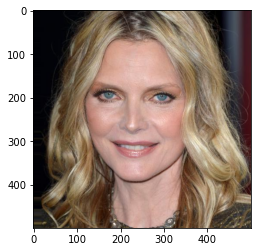

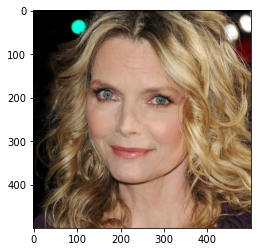

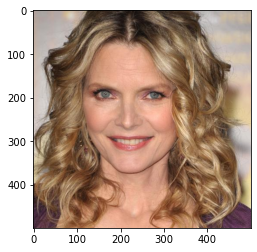

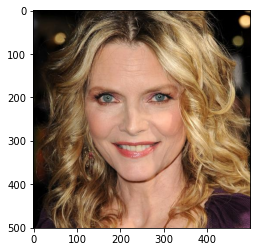

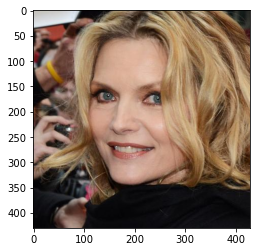

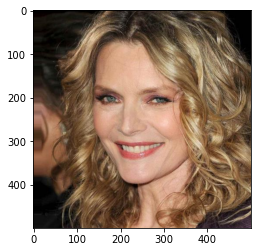

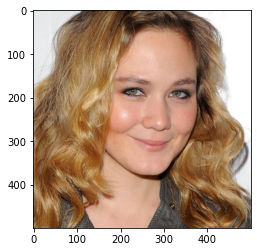

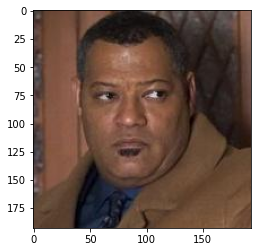

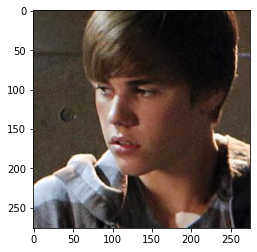

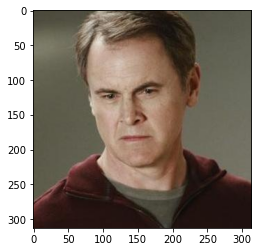

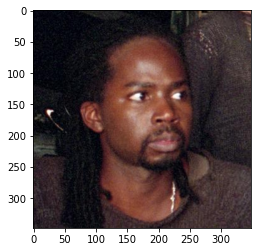

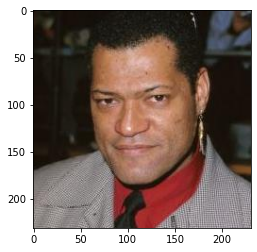

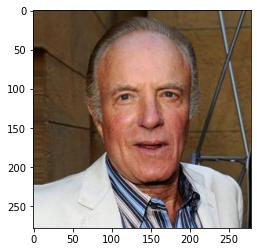

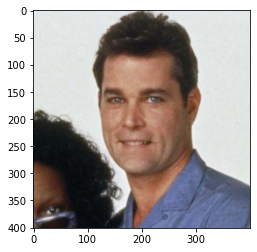

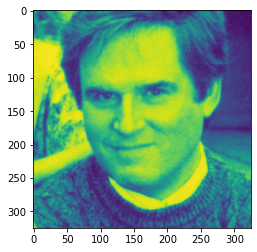

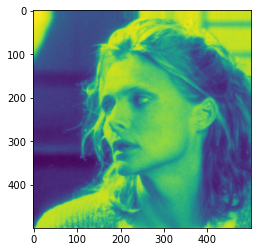

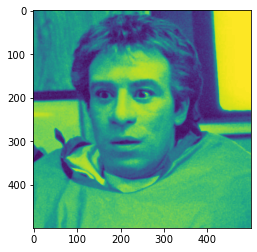

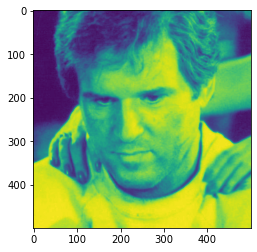

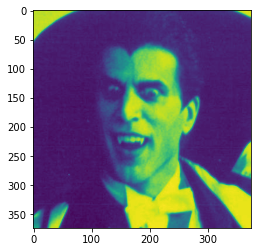

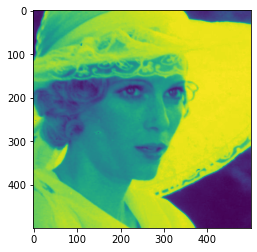

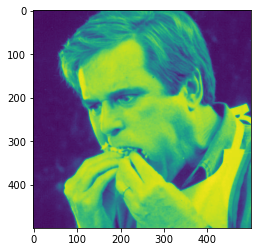

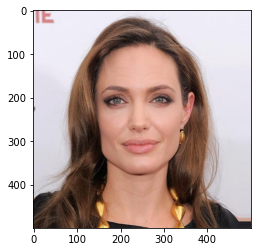

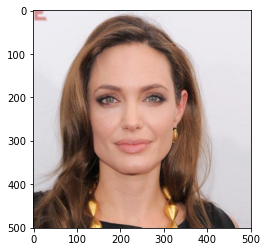

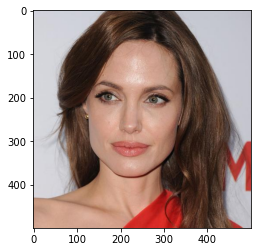

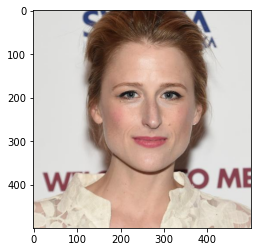

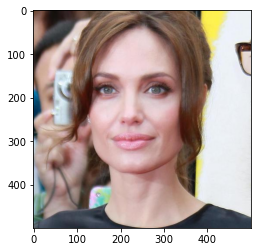

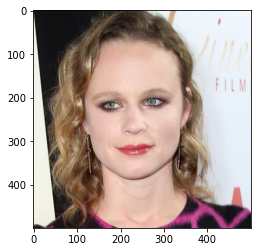

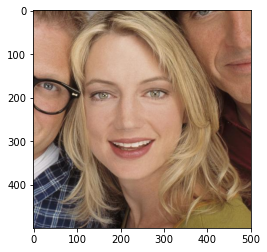

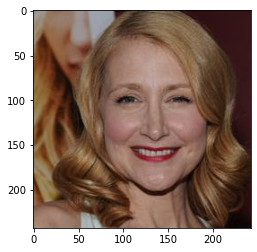

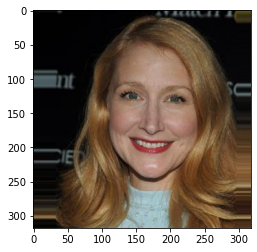

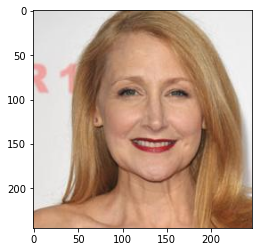

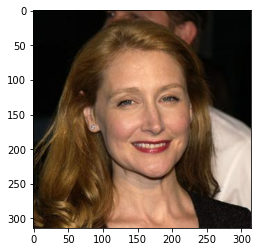

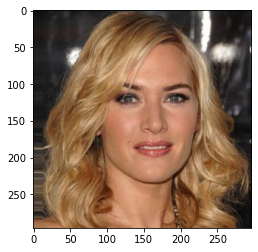

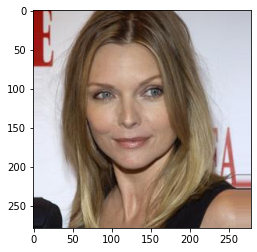

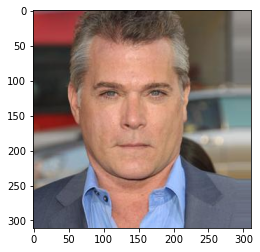

In [47]:
from PIL import Image, ImageFilter, ImageFont, ImageDraw, ImageEnhance
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


for i in clusters:
    for j in i:
        strin = 'imagens/' + j + '.jpg'   #MUDAR PARA 'imagens' quando for rodar as imagens originais sem recorte
        image = mpimg.imread(strin)
        plt.figure()
        plt.imshow(image)



